<a href="https://colab.research.google.com/github/fatdumplingg/BananaRipenessDetectionLevel-KMeansAlgorithm/blob/main/BananaRipenessLevelDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Banana Ripeness Level with Brown Spots Detection

> Goal : to calculate the *ripeness percentage* of the bananas using the ratio of detected brown area and the detected yellow area. The percentage then will decide the *ripeness level* (Newly Ripe / Ripe / Overripe).

> The main method being used is K-Means Clustering with *k* = 3. Why will the image be segmented into 3 clusters?
> * 1 cluster to represent the background
> * 1 cluster to represent the yellow parts of the banana
> * 1 cluster to represent the brown spots found within the bananas.  

> There are **assumptions** for the program to work efficiently :    
> * The background is in a mono (1 color or colors with very similar shades)
> * The area of brown spots is never bigger than the yellow areas in the banana.
> * Since images will only ever be able to capture part of the bananas, please note that in real life, there can be brown spots that go undetected by the image.

> By Sasha Annabel (and team)




###PART 1 : FUNCTIONS

> The *analyze_banana()* function is quite straightforward.
> 1. The K-Means clustering algorithm will get 3 segmented clusters within the image
> 2. Order the clusters by area, and assume that the cluster with biggest area is the background (which will not be put into the formula).
> 3. After deciding which cluster represents 'yellow part' and 'brown spots area', calculate the ripeness level with this formula :
> 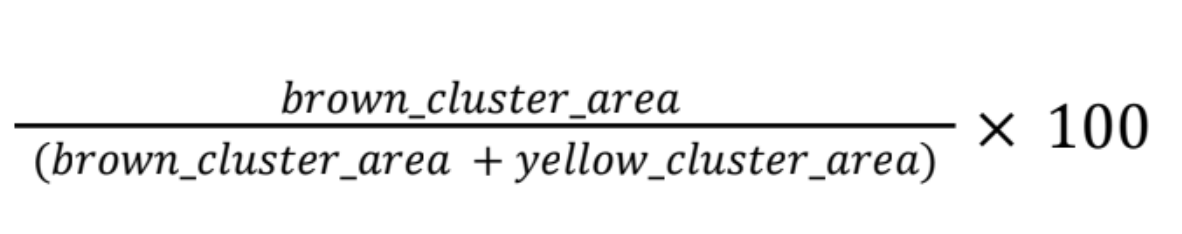

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
def calculate_rgb_distance(color1, color2):
    return np.linalg.norm(np.array(color1) - np.array(color2))

def analyze_banana(image_path, color_difference_threshold=0.3):
    # Read and reshape the image
    pic = plt.imread(image_path) / 255  # dividing by 255 to bring the pixel values between 0 and 1
    pic_n = pic.reshape(pic.shape[0] * pic.shape[1], pic.shape[2])

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pic_n)
    labels = kmeans.labels_

    # Reshape the labels to match the original image shape
    labels_reshaped = labels.reshape(pic.shape[0], pic.shape[1])

    # Display unique cluster labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("Cluster Labels and Counts:")
    for label, count in zip(unique_labels, counts):
        print(f"Cluster {label}: {count} pixels")

    # Find the labels of the clusters with the least and second-least pixels
    least_pixels_cluster = unique_labels[np.argmin(counts)]
    second_least_pixels_cluster = unique_labels[np.argsort(counts)[1]]
    print(f"Cluster with Least Pixels: {least_pixels_cluster}")
    print(f"Cluster with Second-Least Pixels: {second_least_pixels_cluster}")

    # Find the indices of the least and second-least pixels in the labels
    least_pixels_indices = np.where(labels == least_pixels_cluster)
    second_least_pixels_indices = np.where(labels == second_least_pixels_cluster)

    # Extract the colors of the least and second-least pixels
    least_pixels_colors = pic_n[least_pixels_indices]
    second_least_pixels_colors = pic_n[second_least_pixels_indices]

    # Calculate the color difference between the two clusters using RGB values
    color_difference = calculate_rgb_distance(np.mean(least_pixels_colors, axis=0), np.mean(second_least_pixels_colors, axis=0))
    print(f"Color Difference Between Least and Second-Least Pixels: {color_difference}")

    # The two lines below are ADDED AFTER Failed Case 2 (to handle similar colors being clustered differently as no brown spots are visible)
    if color_difference < color_difference_threshold :
      plt.imshow(pic)
      plt.title('Original Image')
      plt.axis('off')
      plt.show()
      print(f"Percentage of brown spots may be less than 3%. Detection limited.")
      return least_pixels_indices + second_least_pixels_indices, 0, 3, 'Newly Ripe'

    # Determine which is the brown_spots_cluster and which is the yellow_cluster
    brown_spots_cluster = least_pixels_cluster
    yellow_cluster = second_least_pixels_cluster

    # Calculate area of the yellow area and brown spots area
    yellow_area = np.sum(labels_reshaped == yellow_cluster)
    brown_spots_area = np.sum(labels_reshaped == brown_spots_cluster)

    # Calculate total area of the image -- not really needed, just in case
    total_area = pic.shape[0] * pic.shape[1]

    # Calculate percentage of brown spots over the BANANA (yellow area + brown spots) area
    percentage_brown_spots_over_yellow = (brown_spots_area / (yellow_area + brown_spots_area)) * 100 if yellow_area != 0 else 0.0

    if percentage_brown_spots_over_yellow <= 40:
      ripeness = 'Ripe'
    else:
      ripeness = 'Overripe'

    # Visualization
    pic2show = kmeans.cluster_centers_[kmeans.labels_]
    cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
    plt.imshow(np.hstack((pic, cluster_pic)))
    plt.title('Original Image | Segmented Image')
    plt.axis('off')
    plt.show()

    return yellow_area, brown_spots_area, percentage_brown_spots_over_yellow, ripeness

###PART 2 : IMPLEMENTATIONS OF SUCCESSFUL CASES

> Below are some cases where the ripeness level can be said to be successfully detected.

####CASE 1 : DARK COLOR HANDLING

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 179363 pixels
Cluster 1: 27267 pixels
Cluster 2: 47350 pixels
Cluster with Least Pixels: 1
Cluster with Second-Least Pixels: 2
Color Difference Between Least and Second-Least Pixels: 0.5212324013058405


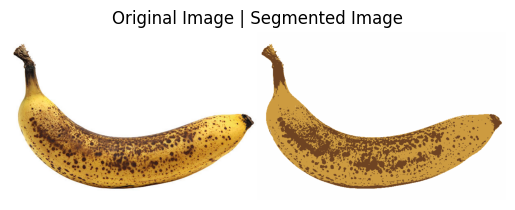

Percentage of brown spots: 36.54261093316536%
Classification: Ripe


In [ ]:
# CASE 1 : dark colored banana
brown_percentage = analyze_banana("/content/banana_3.jpg")

print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")

####CASE 2 : LIGHT COLOR HANDLING

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 72184 pixels
Cluster 1: 232918 pixels
Cluster 2: 9842 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 0
Color Difference Between Least and Second-Least Pixels: 0.43868258961599826


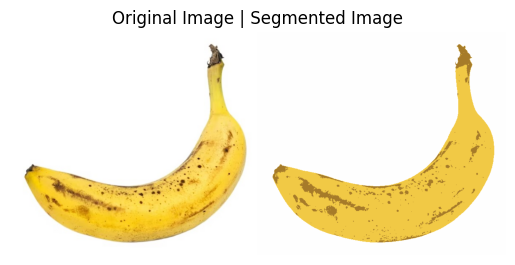

Percentage of brown spots: 11.99863457927974%
Classification: Ripe


In [ ]:
# CASE 2 : light colored banana
brown_percentage = analyze_banana("/content/banana_12.jpg")

print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")

####CASE 3 : MORE THAN 1 BANANA

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 66654 pixels
Cluster 1: 25546 pixels
Cluster 2: 22031 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 1
Color Difference Between Least and Second-Least Pixels: 0.5137278522098003


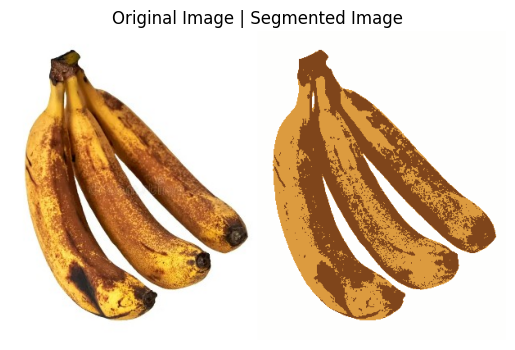

Percentage of brown spots: 46.305988187569625%
Classification: Overripe


In [ ]:
# CASE 3 : more than 1 banana
brown_percentage = analyze_banana("/content/banana_13.jpg")

print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")

####CASE 4 : CLUSTERS OF THE SAME COLOR (HANDLES FAILED CASE 2 --> scroll below)

> This case addresses the drawbacks seen from case 2 of PART 3 : IMPLEMENTATION OF UNSUCCESSFUL CASES.
> As mentioned there, the **color-distance-measurement** is used and now the ripeness classification is correct.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 3349011 pixels
Cluster 1: 636621 pixels
Cluster 2: 773920 pixels
Cluster with Least Pixels: 1
Cluster with Second-Least Pixels: 2
Color Difference Between Least and Second-Least Pixels: 0.18228229871151988


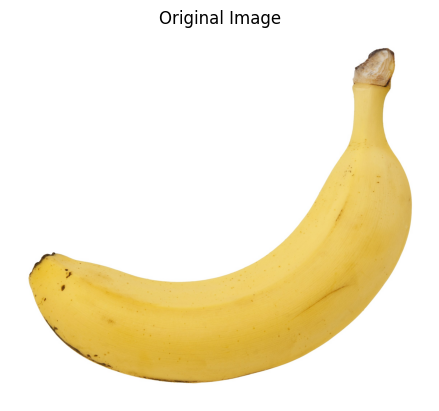

Percentage of brown spots may be less than 3%. Detection limited.
Percentage of brown spots: 3%
Classification: Newly Ripe


In [ ]:
# CASE 4 : clusters of the same color
# Details : due to the Failed Case 2, the code is updated to include color difference threshold
brown_percentage = analyze_banana("/content/banana_6.jpg")

print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")

###PART 3 : IMPLEMENTATIONS OF FAILED CASES --> IMPORTANT LIMITATIONS

> Below are some cases where the ripeness level detection can be said to still be unsuccessful.

####CASE 1 : SHADOW

> When there are many shadowed areas, the 'shadowed area' (even though originally just a yellow part in the banana) has a high chance to be clustered along with the brown spots area due to the nature of the algorithm to cluster colors with similar values.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 247903 pixels
Cluster 1: 64709 pixels
Cluster 2: 31296 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 1
Color Difference Between Least and Second-Least Pixels: 0.43291121863673127


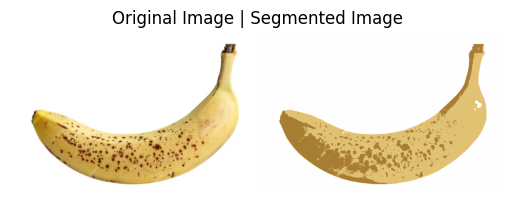

Percentage of brown spots: 32.59830217176189%
Classification: Ripe


In [ ]:
# CASE 1 (shadow)

# Findings : our code has limitations related to lighting in the image during image acquisition.
# Lighting has to be even with no shadows present.

brown_percentage = analyze_banana("/content/banana_8.jpg")

print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")

####CASE 2 : COLOR DIFFERENCE

> In cases where there are no brown spots at all, the algorithm will still attempt to segment the image into 3 clusters. This is not ideal. And so, this problem can be addressed by adding a **color-distance-measurement**.
> * The idea : if the difference between the 2 smallest clusters (ignoring background cluster here) are bigger than a certain thershold, then they belong in separate clusters. Otherwise, they should be grouped in the same cluster.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 3349011 pixels
Cluster 1: 636621 pixels
Cluster 2: 773920 pixels
Cluster with Least Pixels: 1
Cluster with Second-Least Pixels: 2
Color Difference Between Least and Second-Least Pixels: 0.18228229871151988


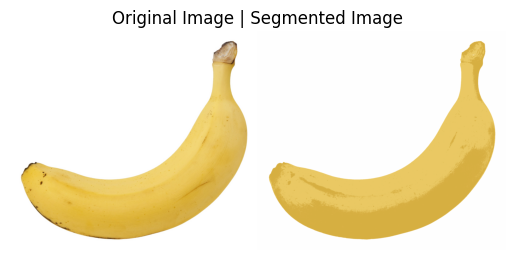

Percentage of brown spots: 45.13310850234059%


In [ ]:
# CASE 2 (color difference between clusters)

# Findings : our initial code is written so that the program will always try to find 3 clusters, even if brown spots don't exist.
# Solution : we check for the color difference between the two clusters (other than the background cluster).
#            if it's less than 0.38, it's likely that the two clusters are of the same very similar color (like dark and light yellow).

brown_percentage = analyze_banana("/content/banana_6.jpg")

print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}%")

###PART 4 : ADDITIONAL TESTCASES


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 96868 pixels
Cluster 1: 347845 pixels
Cluster 2: 29502 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 0
Color Difference Between Least and Second-Least Pixels: 0.697619110051281


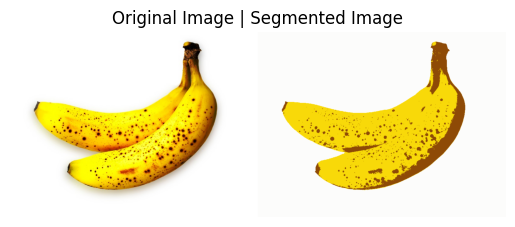

Percentage of brown spots: 23.34573079053573%
Classification: Ripe
Expected Classification : Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest1.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 167718 pixels
Cluster 1: 289050 pixels
Cluster 2: 82323 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 0
Color Difference Between Least and Second-Least Pixels: 0.482560212501286


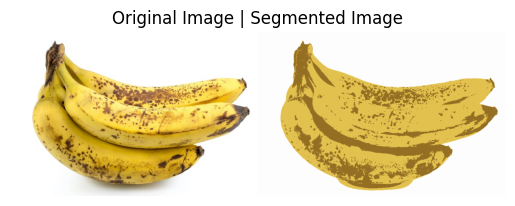

Percentage of brown spots: 32.923800496718535%
Classification: Ripe
Expected Classification : Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest2.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 307574 pixels
Cluster 1: 47032 pixels
Cluster 2: 38610 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 1
Color Difference Between Least and Second-Least Pixels: 0.18898116422497171


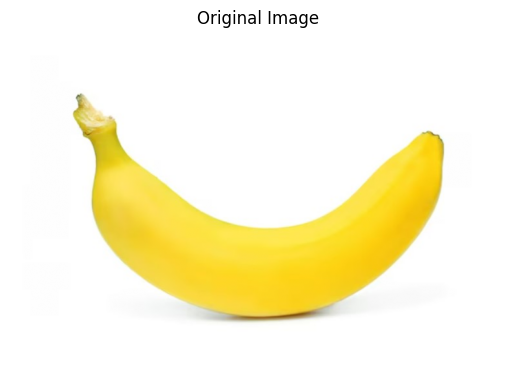

Percentage of brown spots may be less than 3%. Detection limited.
Percentage of brown spots: 3%
Classification: Newly Ripe
Expected Classification : Newly Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest3.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Newly Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 223149 pixels
Cluster 1: 96562 pixels
Cluster 2: 36101 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 1
Color Difference Between Least and Second-Least Pixels: 0.4287809416805979


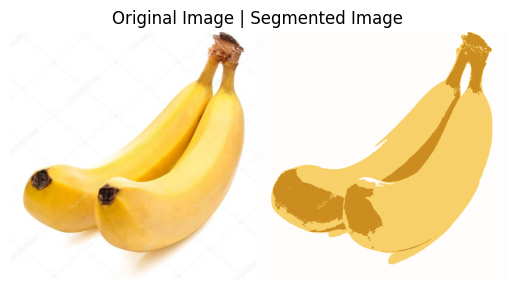

Percentage of brown spots: 27.212561151187597%
Classification: Ripe
Expected Classification : Newly Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest4.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Newly Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 303253 pixels
Cluster 1: 76877 pixels
Cluster 2: 40405 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 1
Color Difference Between Least and Second-Least Pixels: 0.4935942022319769


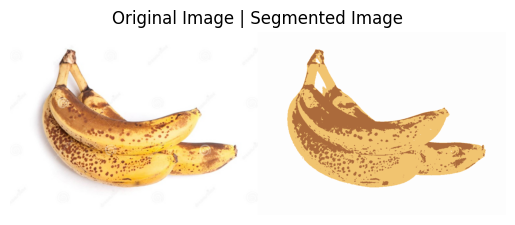

Percentage of brown spots: 34.45115192442148%
Classification: Ripe
Expected Classification : Overripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest5.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Overripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 336738 pixels
Cluster 1: 154926 pixels
Cluster 2: 51340 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 1
Color Difference Between Least and Second-Least Pixels: 0.4353839554538403


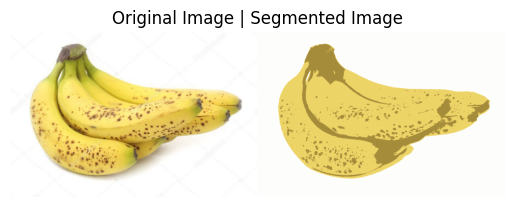

Percentage of brown spots: 24.890190336749633%
Classification: Ripe
Expected Classification : Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest6.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 92798 pixels
Cluster 1: 273678 pixels
Cluster 2: 44908 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 0
Color Difference Between Least and Second-Least Pixels: 0.3746658269729761


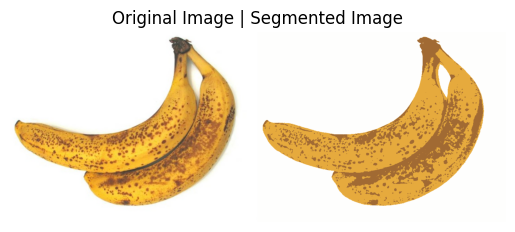

Percentage of brown spots: 32.61150567150305%
Classification: Ripe
Expected Classification : Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest7.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 323959 pixels
Cluster 1: 149592 pixels
Cluster 2: 46001 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 1
Color Difference Between Least and Second-Least Pixels: 0.5332848010851452


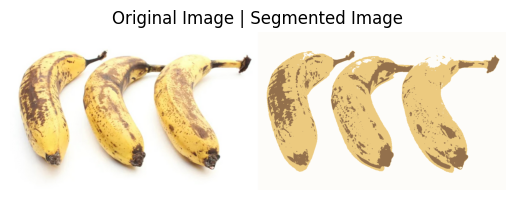

Percentage of brown spots: 23.51873533306407%
Classification: Ripe
Expected Classification : Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest8.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 175531 pixels
Cluster 1: 65196 pixels
Cluster 2: 28073 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 1
Color Difference Between Least and Second-Least Pixels: 0.5348439166925302


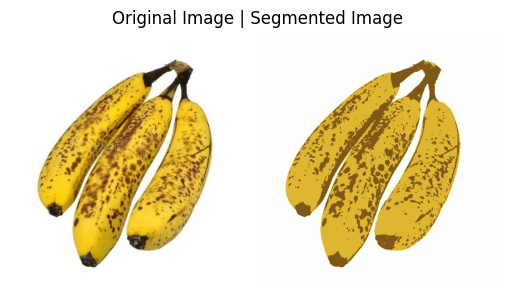

Percentage of brown spots: 30.0989610695944%
Classification: Ripe
Expected Classification : Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest9.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 43620 pixels
Cluster 1: 200769 pixels
Cluster 2: 24614 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 0
Color Difference Between Least and Second-Least Pixels: 0.5300564502562801


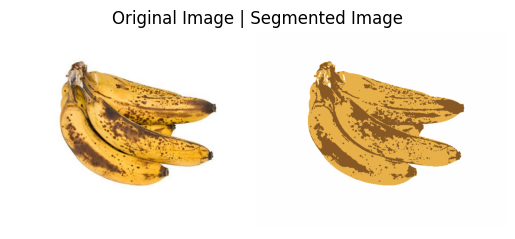

Percentage of brown spots: 36.07292552100126%
Classification: Ripe
Expected Classification : Ripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest10.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Ripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 96318 pixels
Cluster 1: 371748 pixels
Cluster 2: 78855 pixels
Cluster with Least Pixels: 2
Cluster with Second-Least Pixels: 0
Color Difference Between Least and Second-Least Pixels: 0.6338736627928033


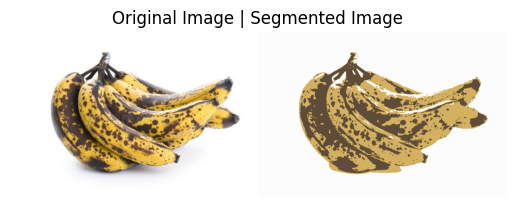

Percentage of brown spots: 45.01549896388142%
Classification: Overripe
Expected Classification : Overripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest11.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Overripe")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels and Counts:
Cluster 0: 46746 pixels
Cluster 1: 9361 pixels
Cluster 2: 12410 pixels
Cluster with Least Pixels: 1
Cluster with Second-Least Pixels: 2
Color Difference Between Least and Second-Least Pixels: 0.5024875610911711


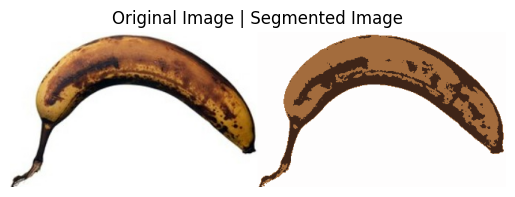

Percentage of brown spots: 42.99756556887603%
Classification: Overripe
Expected Classification : Overripe


In [ ]:
brown_percentage = analyze_banana("/content/bananatest12.jpg")
print(f"Percentage of brown spots: {brown_percentage[2]}%")
print(f"Classification: {brown_percentage[3]}")
print(f"Expected Classification : Overripe")